[View in Colaboratory](https://colab.research.google.com/github/kumarshankar/FADML-Project/blob/master/FADML_wannacry1.ipynb)

In [5]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

In [7]:
from google.colab import files
uploaded = files.upload()

Saving ransomware.txt to ransomware.txt
Saving regular.txt to regular.txt
Saving spec.txt to spec.txt


In [8]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "ransomware.txt" with length 68117 bytes
User uploaded file "regular.txt" with length 6506664 bytes
User uploaded file "spec.txt" with length 410860 bytes


In [0]:
ransom_data = pd.read_csv("ransomware.txt",sep=',',names=[ 'instructions','cache-references','cache-misses','branches','branch-misses'])
regular_data = pd.read_csv("regular.txt",sep=',',names=[ 'instructions','cache-references','cache-misses','branches','branch-misses'])
spec_data = pd.read_csv("spec.txt",sep=',',names=[ 'instructions','cache-references','cache-misses','branches','branch-misses'])

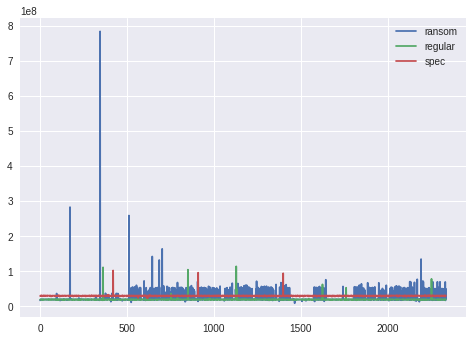

In [10]:
instrcomp = pd.DataFrame({'regular': regular_data.instructions,
                          'ransom': ransom_data.instructions,
                          'spec': spec_data.instructions})
instrcomp = instrcomp.iloc[:2335,:]

instrcomp.plot()

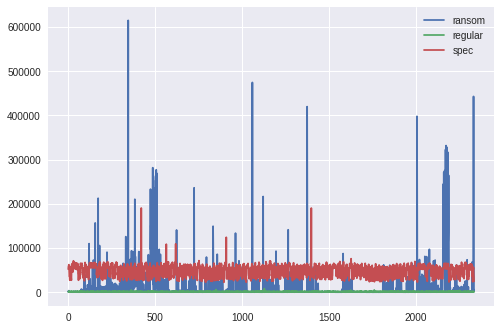

In [11]:
cacrefcomp = pd.DataFrame({'regular': regular_data[regular_data.columns[1]],
                          'ransom': ransom_data[ransom_data.columns[1]],
                          'spec': spec_data[spec_data.columns[1]] })

cacrefcomp = cacrefcomp.iloc[:2335,:]

cacrefcomp.plot()

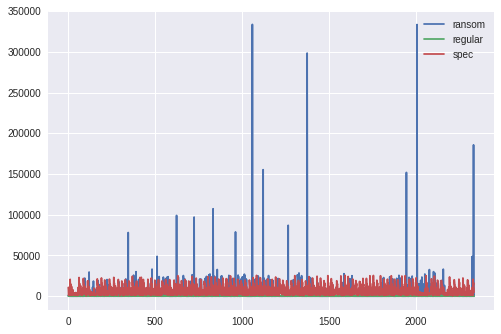

In [12]:
cacmisscomp = pd.DataFrame({'regular': regular_data[regular_data.columns[2]],
                          'ransom': ransom_data[ransom_data.columns[2]],
                          'spec': spec_data[spec_data.columns[2]]})

cacmisscomp = cacmisscomp.iloc[:2335,:]

cacmisscomp.plot()

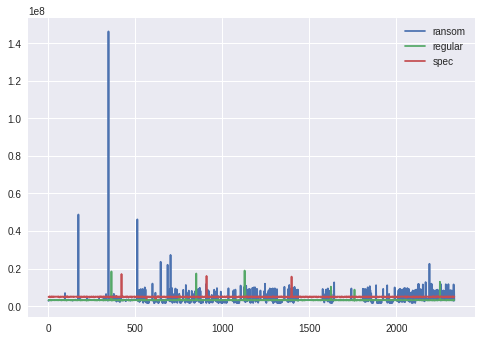

In [13]:
branchescomp = pd.DataFrame({'regular': regular_data.branches,
                          'ransom': ransom_data.branches,
                          'spec': spec_data.branches})

branchescomp = branchescomp.iloc[:2335,:]

branchescomp.plot()

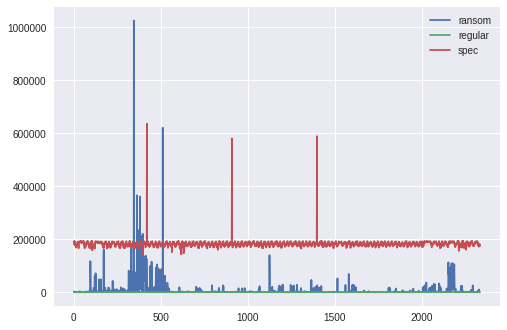

In [14]:
branchmisscomp = pd.DataFrame({'regular': regular_data[regular_data.columns[4]],
                          'ransom': ransom_data[ransom_data.columns[4]],
                          'spec': spec_data[spec_data.columns[4]]})

branchmisscomp = branchmisscomp.iloc[:2335,:]

branchmisscomp.plot()
plt.show()

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(regular_data)
regular_normalized = pd.DataFrame(np_scaled)
regular_normalized = regular_normalized.rename(columns= {0: 'instructions',
                                                         1:'cache-references',
                                                         2:'cache-misses',
                                                         3:'branches',
                                                         4:'branch-misses'})

In [0]:
sequence_length = 51
result = []
for index in range(len(regular_normalized.instructions) - sequence_length):
    result.append(regular_normalized.instructions[index: index + sequence_length])
result = np.array(result)

In [0]:
reg_size_instructions = np.round(0.8 * result.shape[0])
train = result[:int(reg_size_instructions), :]
np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]
x_test = result[int(reg_size_instructions):, :-1]
y_test = result[int(reg_size_instructions):, -1]

In [0]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [21]:
model = build_model([1, 50, 100, 1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  import sys


> Compilation Time :  0.018659114837646484


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [23]:
model.fit(
	    x_train,
	    y_train,
	    batch_size=512,
	    epochs=1,
	    validation_split=0.05)

Train on 170280 samples, validate on 8963 samples
Epoch 1/1
170280/170280 [==============================] - 220s 1ms/step - loss: 4.6138e-05 - val_loss: 2.4316e-05


In [0]:
from numpy import newaxis

In [0]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [3]:
predictions = predict_sequences_multiple(model, x_test, 50, 50)

NameError: ignored

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    plt.legend()
    plt.show()

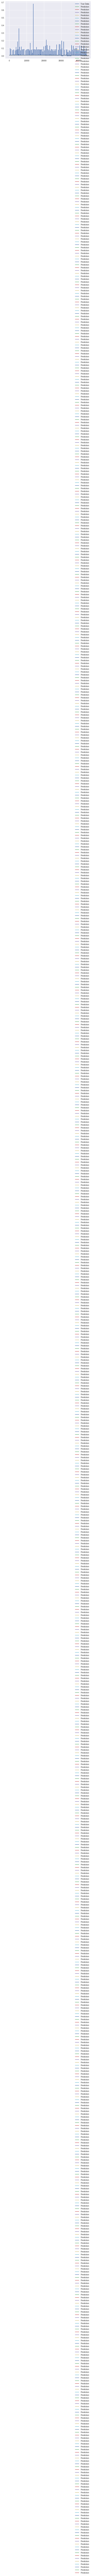

In [28]:
plot_results_multiple(predictions, y_test, 50)